In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

#m21[i] = -2.5*np.log10(F_av_ESN[i])+17.40
#m21_e[i] = (2.5/np.log(10))*(eF_av_ESN[i]/F_av_ESN[i])
F21 = 10**(-0.4*(df.m21-17.40))   # HI 21cm Flux [Jy.km/s]
eF21 = (df.em21/(2.5/np.log(10)))*F21
df['F21'] = F21
df['eF21'] = eF21


df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1', 'w2',
       ...
       'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi',
       'F21', 'eF21'],
      dtype='object', length=118)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,DM_75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,F21,eF21
PGC,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,34.024557,-34.024557,-34.024557,-34.024557,-34.024557,-22.134557,-21.504557,0.00,4.729334,0.805837
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,33.717026,-18.127026,-18.387026,-18.597026,-18.647026,-17.647026,-17.277026,0.47,1.926637,0.134862
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,34.620362,-34.620362,-34.620362,-34.620362,-34.620362,-21.030362,-20.390362,0.00,3.400948,0.579492
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,34.281429,-19.921429,-20.421429,-20.701429,-20.881429,-20.291429,-19.581429,0.78,1.194538,0.203539
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,33.894131,-18.364131,-18.574131,-18.674131,-18.724131,-17.694131,-17.264131,0.31,4.541507,0.317899


In [4]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [5]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Flux
PGC,
2,4.73
4,1.85
6,0.82
12,3.40
16,1.19


In [6]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

In [7]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)

len(dg)

df["F21"] = dg.F21_
df["eF21"] = dg.F21_e

<ipython-input-7-b6dbfbfb12cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-7-b6dbfbfb12cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


In [8]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [9]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

# alfa = 0.3467
# beta = 1.6527

alfa = 0.4356745719231558 
beta = 1.5772902772798747

df['logMs_i'] = beta + alfa*df.gi - 0.4*df['Mi_75']
df['Ms_i'] = 10**df.logMs_i

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

2.319866812287401 -4.918479668117827


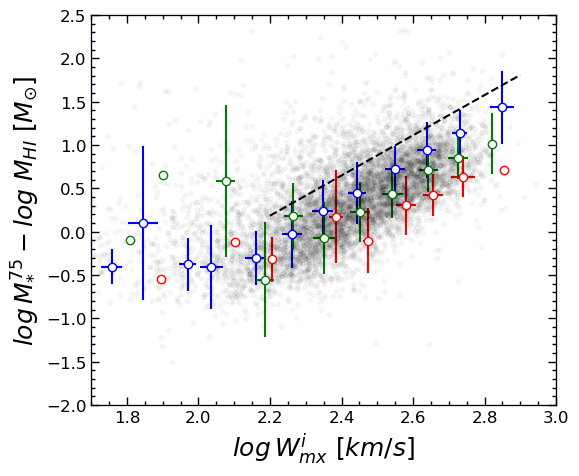

In [10]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# dff = df[(df.elgWi>0)&(df.lgWmxi>0)&((df.Qs>2)|(df.Qw>2))]
# dff['logMs'] = dff[["logMs_i", "logMs_W1"]].mean(axis=1)
# dff = dff[["logMs", "lgWmxi", "Mass_HI", "Vmod"]].dropna()

dff = df[(df.elgWi>0)&(df.lgWmxi>0)&(df.Qs>2)]
                                     
X0 = dff.lgWmxi.values
Y0 = dff.logMs_i.values-np.log10(dff.Mass_HI.values)
Vmod = dff.Vmod.values
ax.plot(X0, Y0, 'k.', alpha=0.03)

label=r'$4000<V_{mod}<5000$'
ind, = np.where((Vmod>4000)&(Vmod<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(1.7,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label=r'$9000<V_{mod}<11000$'
lab = True
ind, = np.where((Vmod>9000)&(Vmod<10000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(1.7,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)            
        
        
label=r'$15000<V_{mod}$'
lab = True      
ind, = np.where((Vmod>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(1.7,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{*}^{75}-log \/\/ M_{HI} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (-2,2.5), fontsize=12)




x = np.linspace(2.2, 2.9, 100)
ind, = np.where((X0>2.2)&(dff.Vmod>0)&(dff.Vmod<2000)&(X0<2.9))
fit, cov = curve_fit(linear, X0[ind], Y0[ind])
m, b = fit[0], fit[1]
ax.plot(x, m*x + b, '--', color='k', label=r'$V_{mod}<2000 \/\/ km/s$')


print(m, b)

m = 2.3984715448143756 
b = -5.140622547056767

array([ 2.60408910e-08, -2.35781935e-04,  2.96873865e-01])

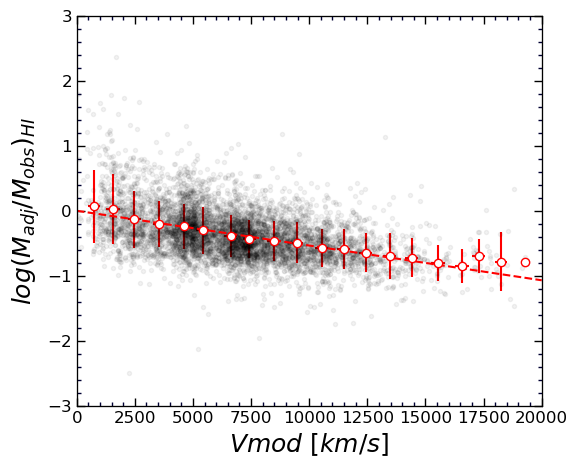

In [11]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = Y0-(m*X0+b)
X = Vmod

X = X[X0>2.2]
Y = Y[X0>2.2]

ax.plot(X, Y, 'k.', alpha=0.05)


for i in np.arange(0, 20000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe) 

x = np.linspace(0,20000,1000)
fit, cov = curve_fit(linear_m, X[X>4000], Y[X>4000])
mc = fit[0]  #; bc=fit[1]
# ax.plot(x, mc*x, '--', color='k')
# print(mc)

mc = -5.348168921793071e-05
ax.plot(x, mc*x, '--', color='r')

ff = np.polyfit(X[(X<5000)&(Y>-3)], Y[(X<5000)&(Y>-3)], 2)
x = np.linspace(0,5000,1000)
y = x*0.
n = len(ff)
for i in range(n):
    y += ff[i]*x**(n-i-1)

    
# ax.plot(x, y, '--', color='g')

ax.set_ylabel(r'$log (M_{adj}/M_{obs})_{HI}$', fontsize=18) 
ax.set_xlabel(r'$Vmod \/\/ [km/s] $', fontsize=18)
set_axes(ax, (0, 20000), (-3,3), fontsize=12)

ff

In [12]:
def HI_corrector(fit, mc, bc, Vmod, Vlim=4000, simple=True):
    
    
#     fit = fit*0
#     mc = mc * 0
#     bc = bc * 0
    
    try:
        y1 = Vmod*0.
        n = len(fit)
        for i in range(n):
            y1 += fit[i]*Vmod**(n-i-1)    

        y2 = mc*Vmod+bc

        y = np.asarray([y1[i] if Vmod[i]<=Vlim else y2[i] for i in range(len(Vmod))])
        if simple:
            return y2
        return y
    except:
        if simple:
            return mc*Vmod+bc
        if Vmod<Vlim:
            y = 0.
            n = len(fit)
            for i in range(n):
                y += fit[i]*Vmod**(n-i-1)  
            return y
        else:
            return mc*Vmod+bc
    
    

Text(1.7650000000000001, -23.200000000000003, '$V_{mod}< 4000\\/\\/\\/km\\/s^{-1}$')

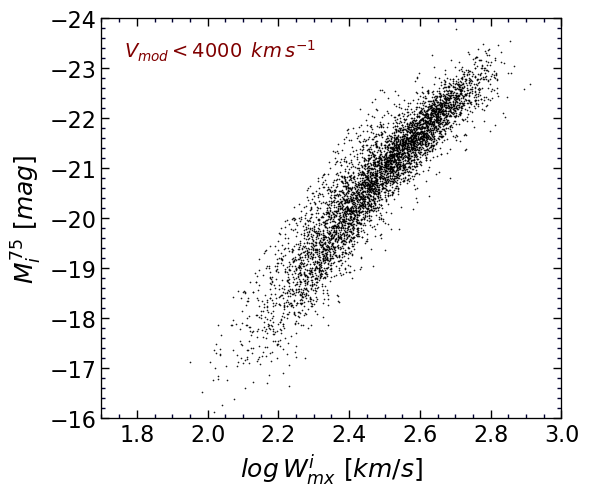

In [101]:
def bilinear2(x, m1, b1, m2, b2):
    y1 = m1 * x + b1
    y2 = m2 * x + b2
    y = np.asarray([y1[i] if x[i]<=M0 else y2[i] for i in range(len(x))])
    return y

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)]

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

X0 = dff.lgWmxi.values
X0e = dff.elgWi.values
Y0 = dff.Mi_75.values
ID = dff.index.values


def bilinear(x, m1, b1, m2, eps):
    x0 = -20+eps 
    b2 = b1 - x0*(m2-m1)
    y1 = m1 * x + b1
    y2 = m2 * x + b2
    y = np.asarray([y1[i] if x[i]<=x0 else y2[i] for i in range(len(x))])
    return y



fit, cov = curve_fit(bilinear, Y0, X0-2.5, sigma=np.sqrt(X0e**2+0.01**2))
M0 = -20+fit[3] 


fit, cov = curve_fit(bilinear2, Y0, X0-2.5, sigma=np.sqrt(X0e**2+0.01**2))
m1 = fit[0] ; dm1 = cov[0][0]
b1 = fit[1] ; db1 = cov[1][1]
m2 = fit[2] ; dm2 = cov[2][2]
b2 = fit[3] ; db2 = cov[3][3]

m1e = np.sqrt(dm1)
b1e = np.sqrt(db1)
mbe = cov[1,0]    
m10 = 1./m1
b10 = -b1/m1
dm10 = np.abs(m1e/m1**2)
db10 = np.sqrt((b10**2 )*(b1e**2/b1**2+m1e**2/m1**2-2*mbe/m1/b1))


m2e = np.sqrt(dm2)
b2e = np.sqrt(db2)
mbe = cov[2,3]    
m20 = 1./m2
b20 = -b2/m2
dm20 = np.abs(m2e/m2**2)
db20 = np.sqrt((b20**2 )*(b2e**2/b2**2+m2e**2/m2**2-2*mbe/m2/b2))

v = np.linspace(-24,M0,100)
u = m1*v + b1 + 2.5
# ax.plot(u, v, '-', color='black')
v = np.linspace(M0,-14,100)
u = m2*v + b2 + 2.5
# ax.plot(u, v, '-', color='purple')


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$M^{75}_{i} \/\/ [mag]$', fontsize=18)
set_axes(ax, (1.7,3), (-16,-24))



# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.90*Ylm[1]
# ax.text(x0,y0, r"$Slope_H = $"+"%.2f" % m10+'$\pm$'+"%.2f" % dm10, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.80*Ylm[1]
# ax.text(x0,y0, r"$ZP_H = $"+"%.2f" % b10+'$\pm$'+"%.2f" % db10, fontsize=12, color='k')
# y0 = 0.3*Ylm[0]+0.70*Ylm[1]
# ax.text(x0,y0, r"$M_0 = $"+"%.2f" % (M0), fontsize=12, color='maroon')


# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.42*Xlm[0]+0.58*Xlm[1]
# y0 = 0.80*Ylm[0]+0.2*Ylm[1]
# ax.text(x0,y0, r"$Slope_L = $"+"%.2f" % m20+'$\pm$'+"%.2f" % dm20, fontsize=12, color='purple')
# y0 = 0.90*Ylm[0]+0.10*Ylm[1]
# ax.text(x0,y0, r"$ZP_L = $"+"%.2f" % b20+'$\pm$'+"%.2f" % db20, fontsize=12, color='purple')


Wh = (M0-b10)/m10+2.5
Wl = (M0-b20)/m20+2.5

W0 = 0.5*(Wh+Wl)

N = len(X0)
Mfid = np.zeros(N)
for i in range(N):
    
    if X0[i]<W0:
        Mf = m20*(X0[i]-2.5)+b20
    else:
        Mf = m10*(X0[i]-2.5)+b10
    
    Mfid[i] = Mf
    
delta = Y0-Mfid
keep, = np.where(np.abs(delta)<2.0*np.std(delta))

## scatter plot
ax.plot(X0[keep], Y0[keep], 'ko', alpha=0.9, ms=1.2, mfc='k', mec='none') 


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, r"$V_{mod}< 4000\/\/\/km\/s^{-1}$" % dm20, fontsize=14, color='maroon')

2.4450275454733426

In [13]:
PGC_outlier_1 = [    356,    1286,    1553,    2080,    2266,    2768,    3084,
          3174,    3235,    3717,    3763,    5043,    6054,    6438,
          6966,    6982,    9399,   15460,   21673,   22381,   23355,
         27640,   30358,   32707,   35942,   36349,   36466,   42938,
         43726,   45887,   50012,   51450,   53728,   66948,   67511,
         69016,   83427,   84490,   90431,   90844,   91252,  142838,
        142840,  169737, 4310833, 5057394, 5057398]

PGC_outlier_2 = [   2712,    3081,    3133,    3247,    4387,    6889,    9134,
         36778,   53291,   70708,   71795,   85607,  138562,  142824,
        169989,  170138, 1056132, 1129847, 5076801]


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-14-b720a01a2e78>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-14-b720a01a2e78>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-14-b720a01a2e78>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy 

iter:  0
iter:  1
3.26 10.316529576927188
2.8627133832627387 10.300760791230331


Text(2.4539999999999997, 7.5, '$ZP = $10.32$\\pm$0.00')

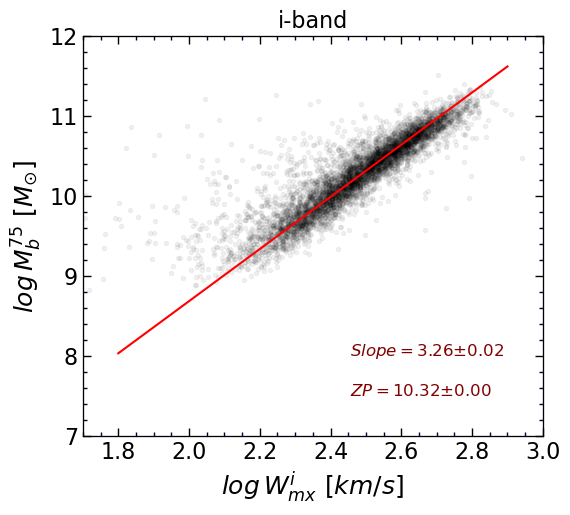

In [14]:
df['Mb'] = df.Ms_i + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(ff, mc, 0, df.Vmod.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    Vmod = dff.Vmod.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_W1.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
    fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
    m = fit[0]
    b = fit[1]
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), 0.*dlogMb+0.01, clip=3.)    

    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 


# ID = dff.index.values
# for i in range(len(ID)):
#     if ID[i] in PGC_outlier_1:
#         ax.plot([logW[i]], [logMass[i]], 'r.', alpha=0.5)
#     if ID[i] in PGC_outlier_2:
#         ax.plot([logW[i]], [logMass[i]], 'b.', alpha=0.5)
  

m0 = 3.26
w = np.linspace(1.8,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'r-')
print(m0,b0)    

    
# ax.plot(w, m*(w-2.5)+b, 'b-')
print(m,b)
   
# mf = mcfit.ab[1]
# bf = mcfit.ab[0]
# ax.plot(w, mf*(w-2.5)+bf, 'g-')
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (7,12))

ax.set_title("i-band", fontsize=16)



# X = logW
# Y = logMass
# for i in np.arange(2,2.9,0.1):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.1:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='magenta', ms=6, mfc='white')   
        
# for i in np.arange(8,12,0.5):
#     xp = []
#     yp = []
#     for ii in range(len(Y)):
#         xi = Y[ii]
#         if xi>=i and xi<i+0.5:
#             xp.append(xi)
#             yp.append(X[ii])
#     if len(xp)>0:
#         ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=np.std(yp), fmt='o', 
#                     color='r', ms=6)  
        
        
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.42*Xlm[0]+0.58*Xlm[1]
y0 = 0.80*Ylm[0]+0.2*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='maroon')
y0 = 0.90*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$ZP = $"+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='maroon')



/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1679
1648
88


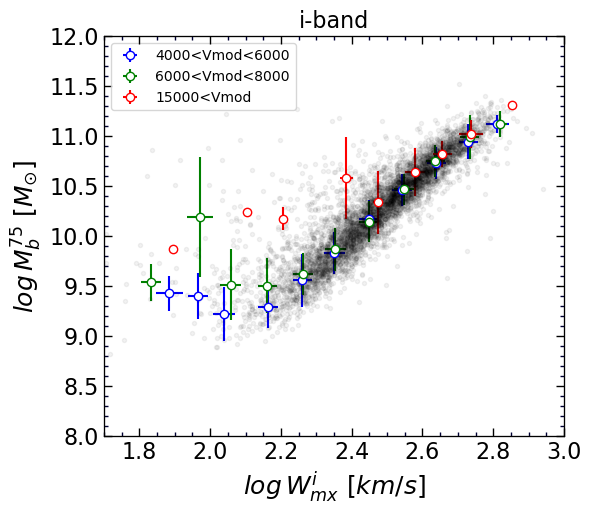

In [15]:
df['Mb'] = df.Ms_i + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(ff, mc, 0, df.Vmod.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)]
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
Vmod = dff.Vmod.values


label='4000<Vmod<6000'
ind, = np.where((Vmod>4000)&(Vmod<6000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label='6000<Vmod<8000'
ind, = np.where((Vmod>6000)&(Vmod<8000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label='15000<Vmod'
ind, = np.where((Vmod>15000)&(Vmod<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("i-band", fontsize=16)

ax.legend()

In [16]:
# class lts_linefit:
#     """
#     LTS_LINEFIT
#     -----------

#     Purpose
#     -------

#     Best straight-line *robust* fit to data with errors in
#     both coordinates while fitting for the intrinsic scatter.
#     See `Cappellari et al. (2013a, Sec.3.2)
#     <https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C>`_

#     Explanation
#     -----------

#     Linear Least-squares approximation in one-dimension (y = a + b*x),
#     when both x and y data have errors and allowing for intrinsic
#     scatter in the relation.

#     Outliers are iteratively clipped using the extremely robust
#     FAST-LTS technique by `Rousseeuw & van Driessen (2006)
#     <http://dx.doi.org/10.1007/s10618-005-0024-4>`_
#     (See also `Rousseeuw 1987)
#     <http://books.google.co.uk/books?id=woaH_73s-MwC&pg=PA15>`_

#     Calling Sequence
#     ----------------

#     .. code-block:: python

#         p = lts_linefit(x, y, sigx, sigy, clip=2.6, epsy=True, corr=True,
#                       frac=None, pivot=None, plot=True, text=True)

#     The output values are stored as attributes of "p".
#     See usage example at the bottom of this file.

#     Input Parameters
#     ----------------

#     x, y:
#         vectors of size N with the measured values.
#     sigx, sigy:
#         vectors of size N with the 1sigma errors in x and y.
#     clip:
#         values deviating more than clip*sigma from the best fit are
#         considered outliers and are excluded from the linear fit.
#     epsy:
#         if True, the intrinsic scatter is printed on the plot.
#     corr:
#         if True, the correlation coefficients are printed on the plot.
#     frac:
#         fractions of values to include in the LTS stage.
#         Up to a fraction "frac" of the values can be outliers.
#         One must have 0.5 < frac < 1  (default frac=0.5).

#         NOTE: Set frac=1, to turn off outliers detection.
#     label:
#         optional string label to create a legend outside the procedure.
#     pivot:
#         if this is not None, then lts_linefit fits the relation::

#             y = a + b*(x - pivot)

#         pivot is called x_0 in eq.(6) of Cappellari et al. (2013)
#         Use of this keyword is *strongly* recommended and a suggested
#         value is pivot ~ np.mean(x). This keyword is important to
#         reduce the covariance between a and b.
#     plot:
#         if True a plot of the fit is produced.
#     text:
#         if True, the best fitting parameters are printed on the plot.

#     Output Parameters
#     -----------------

#     The output values are stored as attributed of the lts_linefit class.

#     p.ab:
#         best fitting parameters [a, b]
#     p.ab_err:
#         1*sigma formal errors [a_err, b_err] on a and b.
#     p.mask:
#         boolean vector with the same size of x and y.
#         It contains True  for the elements of (x, y) which were included in
#         the fit and False for the outliers which were automatically clipped.
#     p.rms:
#         rms = np.std(fit - y) beteween the data and the fitted relation.
#     p.sig_int:
#         intrinsic scatter around the linear relation.
#         sig_int is called epsilon_y in eq.(6) of Cappellari et al. (2013).
#     p.sig_int_err:
#         1*sigma formal error on sig_int.

#     """

In [17]:
def getDMi(mag, Wlog, F21, m0, b0, D, gi, Vmod):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(ff, mc, 0, Vmod))
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - (alfa*gi+beta))
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [18]:
dff = df[(df.Qs>0)&(df.elgWi>0)&(df.lgWmxi>0)]
mag = dff["i***"].values
Wlog = dff.lgWmxi.values
F21 = dff.F21.values
D75 = dff.D75.values
gi = dff.gi.values
Vmod = dff.Vmod.values
PGC = dff.index.values

N = len(dff)
M1_fid = np.zeros(N)
print(N)
pp=0

for j in range(N):
    mag_ = mag[j]

    D = np.arange(600)
    delta = D*0.

    for i in range(600):
        delta[i] =  D[i] - getDMi(mag[j], Wlog[j], F21[j], m0, b0, D[i], gi[j], Vmod[j])


    D = D[~np.isnan(delta)]
    delta = delta[~np.isnan(delta)]

    try:
#         D_left = np.max(D[delta<0])
#         D_right = np.min(D[delta>0])
#         D_root = 0.5*(D_left+D_right)
        D_root = interpol(D, delta)
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid
    except:
        D_root = np.max(D[delta<0])
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid    
        print("flag (j, pgc): ", j, PGC[j])
        pp+=1
    if j%1000==0:
        print(j)
    if PGC[j]==1781:
        print(j, mag_, DM_fid, D_root)

print("Number of concerning distances:", pp)

7502
0


<ipython-input-17-7d00f2367af3>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(ff, mc, 0, Vmod))
<ipython-input-17-7d00f2367af3>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - (alfa*gi+beta))


184 14.61 29.613889048788902 8.371009017380343
1000
2000
3000
4000
5000
6000
7000
Number of concerning distances: 0


<ipython-input-17-7d00f2367af3>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(ff, mc, 0, Vmod))
<ipython-input-17-7d00f2367af3>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - (alfa*gi+beta))


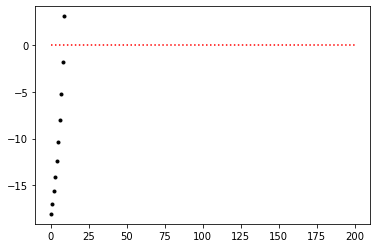

In [19]:
j = 184
D = np.arange(500)
delta = D*0.
for i in range(500):
        delta[i] =  D[i] - getDMi(mag[j], Wlog[j], F21[j], m0, b0, D[i], gi[j], Vmod[j])

plt.plot(D, delta, 'k.') 
plt.plot([0,200], [0,0], "r:")

<ipython-input-20-4c74ad1fb243>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = M1_fid - dff.Mi_75.values


Text(0.5, 1.0, 'BTFR: i-band')

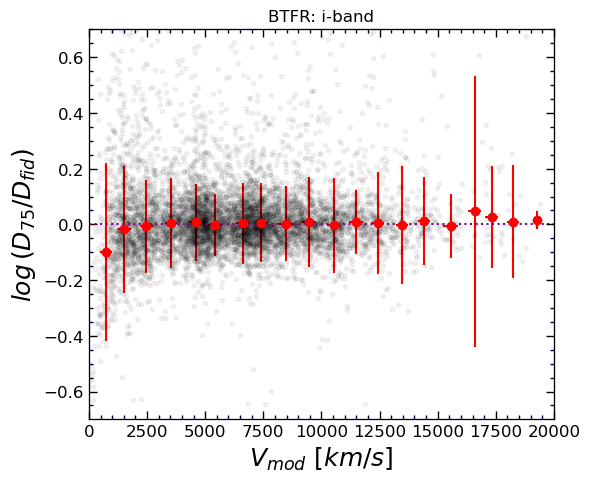

In [20]:
dff['dDM'] = M1_fid - dff.Mi_75.values

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.dDM.values/5
# logW = dff.lgWmxi.values

# X = X[logW>2.3]
# Y = Y[logW>2.3]


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

ax.set_title("BTFR: i-band")

Text(0.5, 1.0, 'BTFR: i-band')

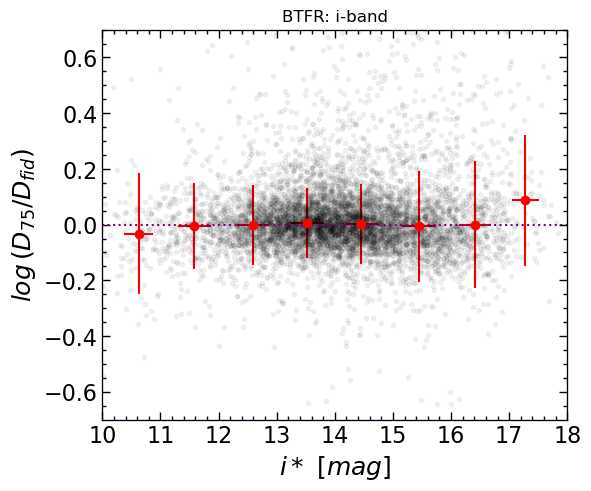

In [21]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['i***'].values
Y = dff.dDM.values/5.
V = dff.Vmod.values


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-0.7,0.7))

ax.set_title("BTFR: i-band")

Text(0.5, 1.0, 'BTFR: i-band')

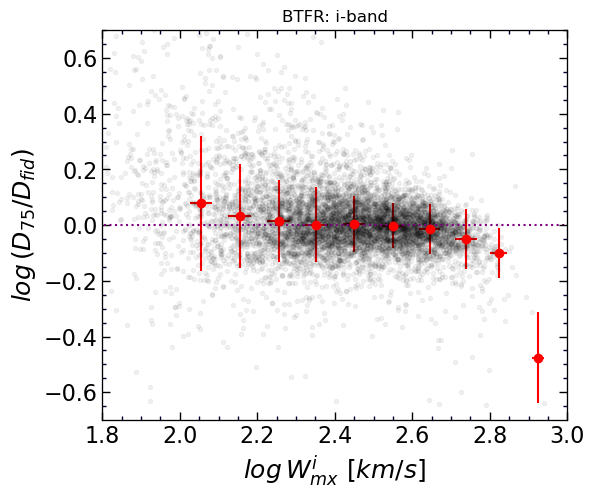

In [22]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.lgWmxi.values
Y = dff.dDM.values/5.
V = dff.Vmod.values


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18)
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')
ax.plot([-10,10], [0,0], ':', color='purple')

set_axes(ax, (1.8,3), (-0.7,0.7))

ax.set_title("BTFR: i-band")

In [23]:
dff['DMi_fid'] = dff["i***"] - M1_fid

dff[['Vmod', 'DM_75', 'DMi_fid', 'F21', 'eF21', 'lgWmxi', 'elgWi', 'Qs', 'i***', 'logMs_i', 'logMs_W1']].to_csv("BTFR_i_distances.csv")

<ipython-input-23-05a66072c46a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DMi_fid'] = dff["i***"] - M1_fid
